<a href="https://colab.research.google.com/github/PyBeginner1/FetalHealthPrediction/blob/main/FetalHealthPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install catboost

In [72]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [73]:
data = pd.read_csv('/content/fetal_health.csv')

In [74]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [76]:
data.isna().sum().sum()

0

# Exploratory Data Analysis

In [77]:
eda_df = data.copy()

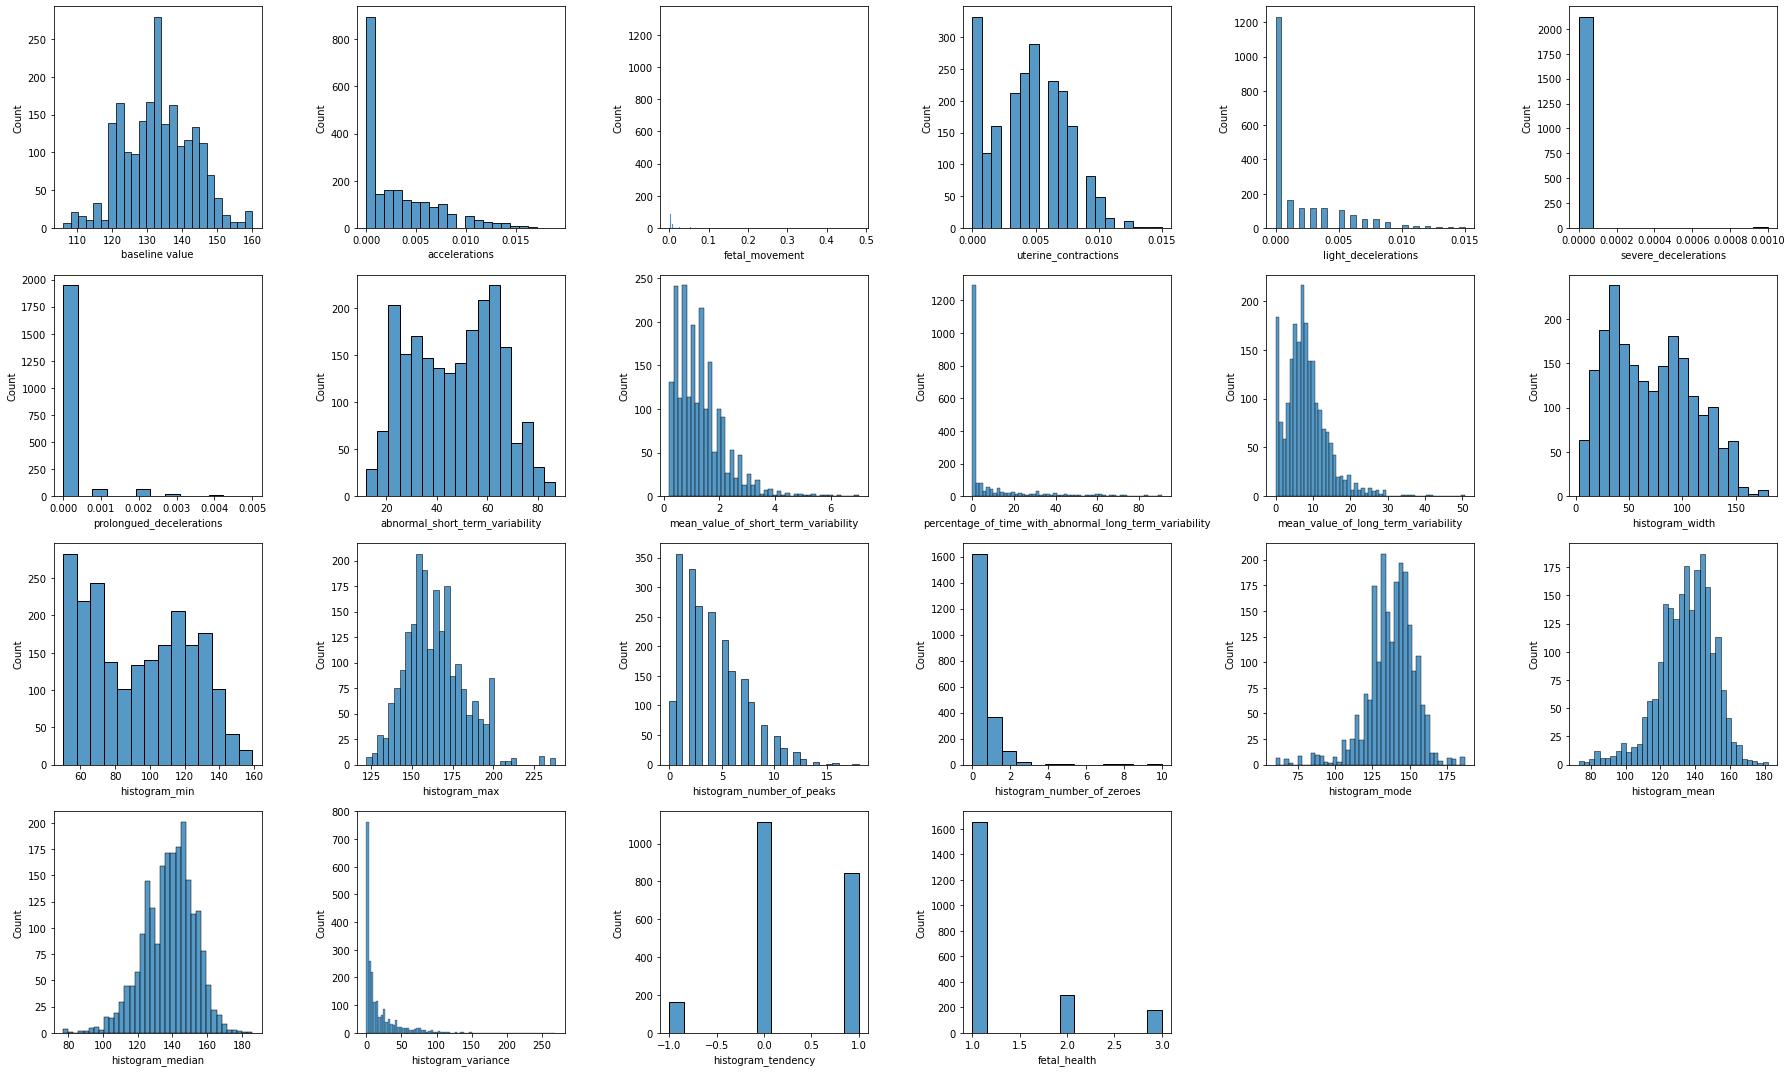

In [78]:
plt.figure(figsize = (25, 15))
for i, column in enumerate(eda_df.columns):
  plt.subplot(4, 6, i + 1)
  sns.histplot(data = eda_df[column])
plt.tight_layout()
plt.show()

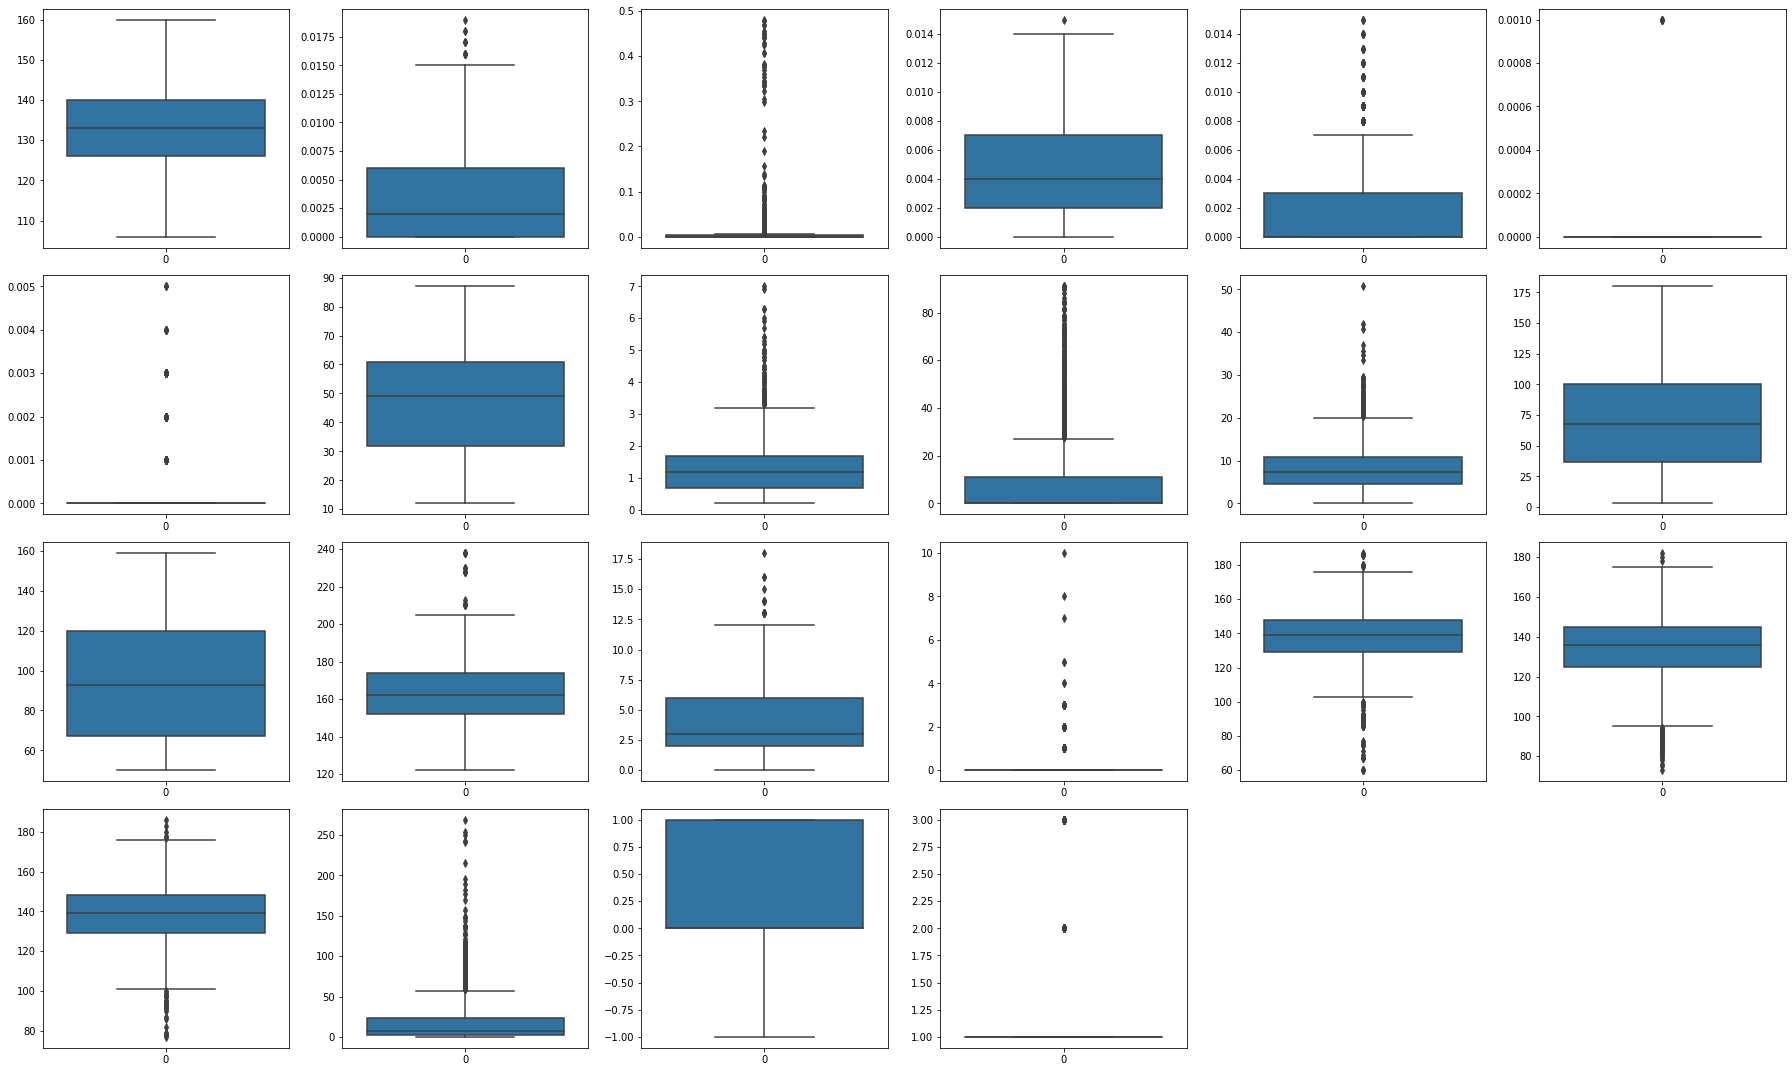

In [79]:
#boxplot
plt.figure(figsize = (25, 15))
for i, column in enumerate(eda_df.columns):
  plt.subplot(4, 6, i + 1)
  sns.boxplot(data = eda_df[column])
plt.tight_layout()
plt.show()

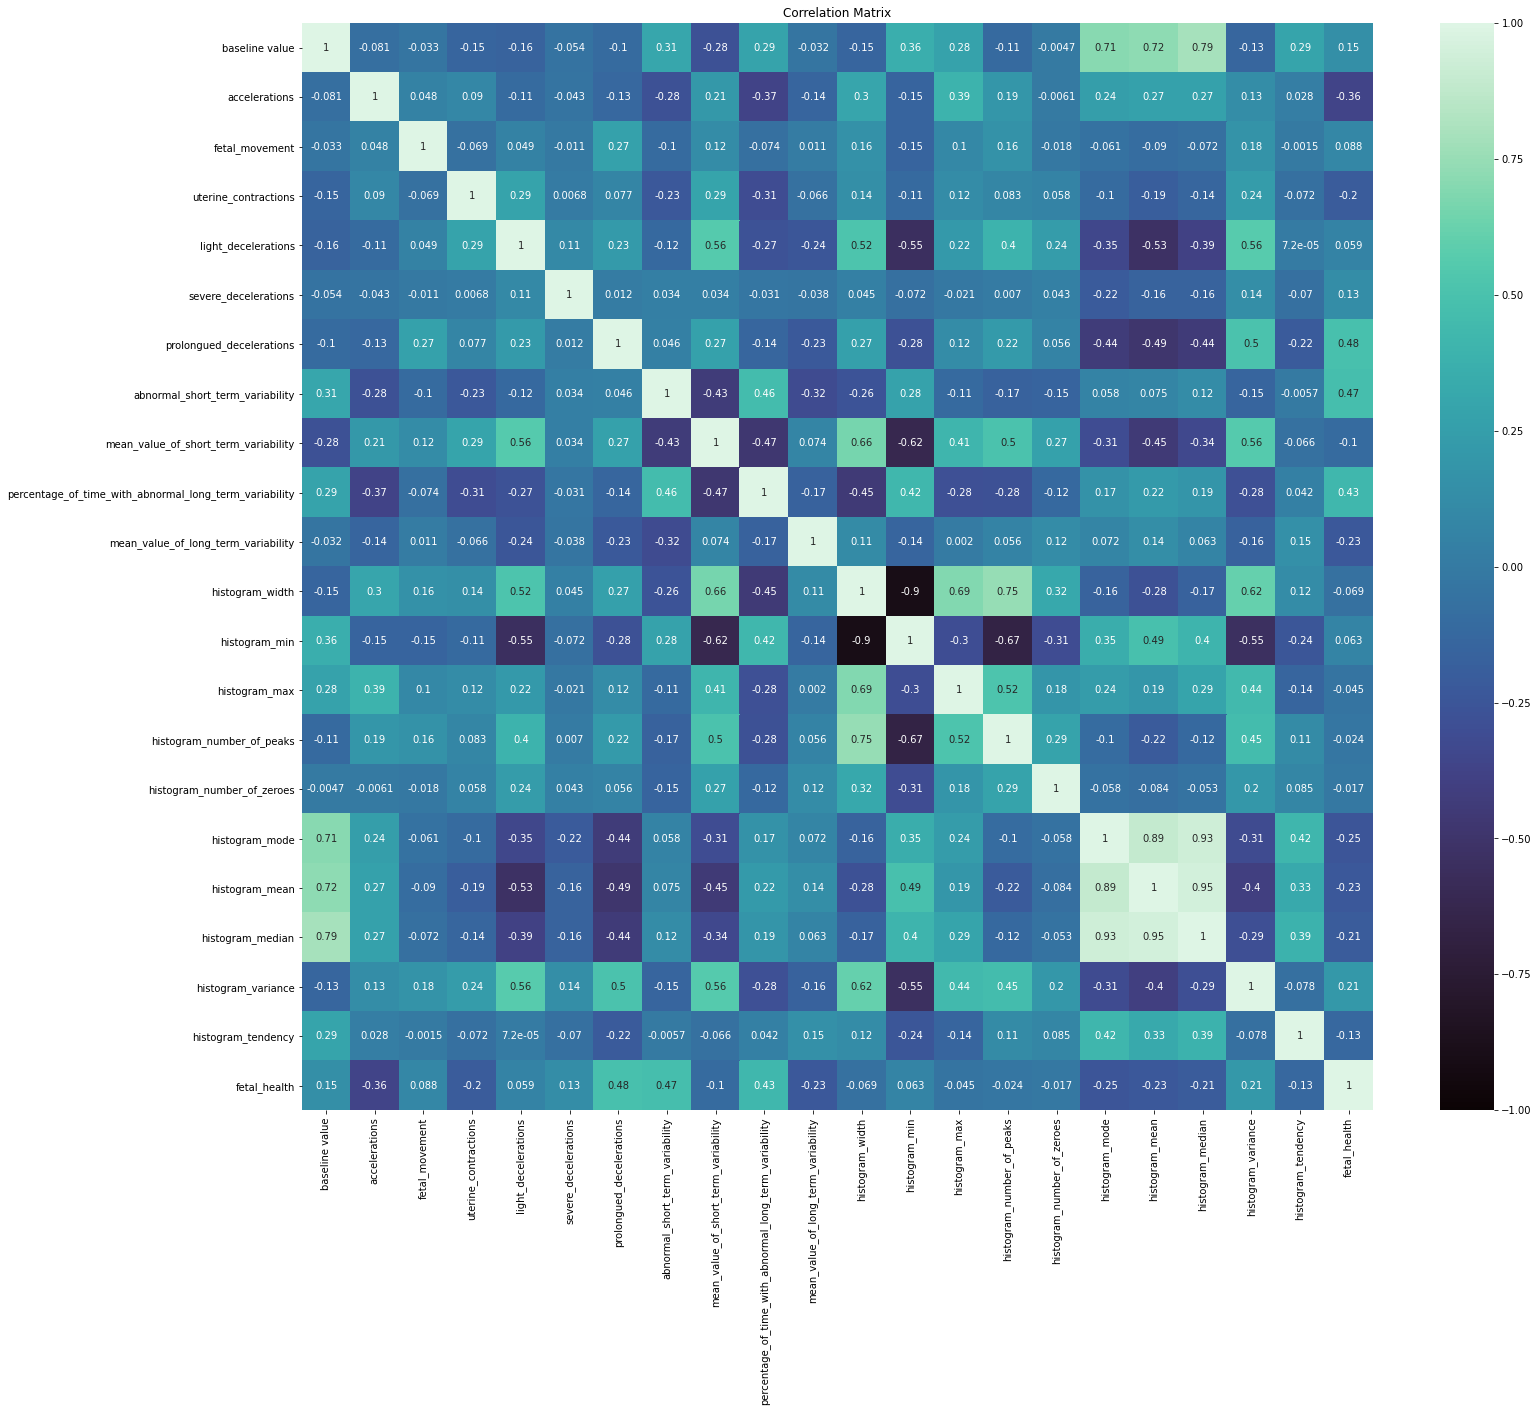

In [80]:
corr = eda_df.corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot = True, cmap = 'mako', vmin = -1.0)
plt.title('Correlation Matrix')
plt.show()

In [81]:
eda_df['fetal_health'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

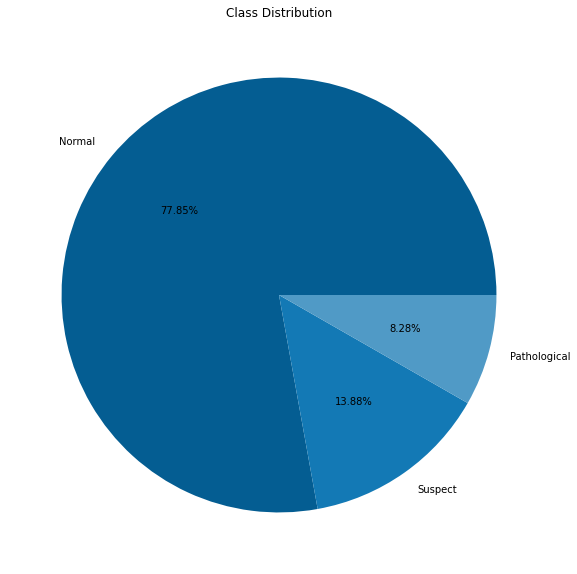

In [82]:
plt.figure(figsize= (10, 10))
plt.pie(
    eda_df['fetal_health'].value_counts(), 
    labels =['Normal', 'Suspect','Pathological'],
    autopct = '%.2f%%',
    colors = sns.color_palette('PuBu_r')
)
plt.title('Class Distribution')
plt.show()

# Preprocessing

In [98]:
def preprocess_inputs(df):
  df = df.copy()

  #rename target column
  df['fetal_health'] = df['fetal_health'].replace({1.0 : 'Normal', 2.0 : 'Suspect', 3.0 : 'Pathological'})

  #split Features & target
  X = df.drop('fetal_health', axis = 1)
  Y = df['fetal_health']

  #train-test split
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,  random_state = 1)

  #scaling
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns= X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns= X_test.columns)

  return X_train, X_test, Y_train, Y_test

In [99]:
X_train, X_test, Y_train, Y_test = preprocess_inputs(data)

In [100]:
X.shape,X_train.shape, X_test.shape

((2126, 21), (1488, 21), (638, 21))

In [101]:
X_train

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
1178,-0.754973,0.731770,-0.204095,0.551513,-0.651135,-0.051917,-0.277438,-1.269308,0.073240,-0.537234,-0.324758,-0.595014,0.477137,-0.506937,-0.716047,-0.454252,-0.263063,0.035465,-0.208156,-0.340585,-0.525276
408,1.740547,-0.822284,-0.204095,-1.477290,-0.316227,-0.051917,-0.277438,1.688720,-1.297591,1.827866,-0.522608,-0.931081,1.023066,-0.338574,-1.061197,-0.454252,1.019938,1.198135,1.178619,-0.618965,1.096324
802,1.324627,-0.822284,-0.204095,0.551513,-0.651135,-0.051917,-0.277438,1.050714,-1.069119,1.277843,-0.126908,-1.060338,1.398392,-0.001848,-1.061197,-0.454252,0.775557,0.939764,0.901264,-0.618965,-0.525276
22,-0.547013,-0.822284,7.146148,-0.462889,0.353589,-0.051917,4.696388,-0.747303,1.329835,-0.537234,-0.738444,1.912562,-1.331252,1.962388,2.390302,0.936543,-3.806591,-2.289874,-2.496335,4.496267,-2.146877
204,-1.378853,-0.822284,-0.028041,-1.477290,-0.651135,-0.051917,-0.277438,0.238707,-0.726411,0.287801,-0.126908,-1.293000,0.545379,-1.909963,-1.061197,0.936543,-0.874016,-0.868833,-1.040221,-0.653763,-0.525276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-0.027113,-0.822284,-0.204095,0.551513,2.363036,-0.051917,-0.277438,-1.559311,1.558307,-0.537234,1.869579,0.697551,-1.024167,-0.170211,1.009703,-0.454252,-0.079777,-0.675055,-0.277495,1.468885,1.096324
905,1.324627,-0.822284,-0.204095,0.889646,1.023405,-0.051917,-0.277438,-0.979305,-0.269468,-0.537234,-0.612540,-0.310650,0.204173,-0.338574,-0.370897,-0.454252,0.592271,0.552207,0.623909,-0.479775,1.096324
1096,-1.066913,3.580871,-0.204095,-0.801023,-0.651135,-0.051917,-0.277438,-1.327308,0.987127,-0.537234,-1.152131,-0.491609,0.238294,-0.675300,-1.061197,-0.454252,-0.079777,-0.093720,-0.208156,-0.479775,-0.525276
235,-1.274873,-0.045257,-0.072054,-1.477290,-0.651135,-0.051917,-0.277438,0.528709,-0.840647,-0.427229,0.430670,0.154673,-1.058287,-1.404874,-0.370897,-0.454252,-0.629635,-0.416684,-0.624189,-0.549370,1.096324


# Model

In [95]:
models = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'K Neighbors' : KNeighborsClassifier(),
    'SVM (Linear Kernel)' : LinearSVC(),
    'SVM (RBF Kernel)' : SVC(),
    'Neural Network' : MLPClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier(),
    'XG Boost' : XGBClassifier(),
    'LGBM' : LGBMClassifier(),
    'Cat Boost' : CatBoostClassifier()
}

for name, model in models.items():
  model.fit(X_train, Y_train)
  print(name + (' trained!'))

Logistic Regression trained!
Decision Tree trained!
K Neighbors trained!
SVM (Linear Kernel) trained!
SVM (RBF Kernel) trained!
Neural Network trained!
Random Forest trained!
Gradient Boosting trained!
XG Boost trained!
LGBM trained!
Learning rate set to 0.080747
0:	learn: 0.9918879	total: 5.3ms	remaining: 5.3s
1:	learn: 0.9122512	total: 9.61ms	remaining: 4.8s
2:	learn: 0.8391121	total: 13.7ms	remaining: 4.57s
3:	learn: 0.7788791	total: 17.9ms	remaining: 4.45s
4:	learn: 0.7292275	total: 22ms	remaining: 4.37s
5:	learn: 0.6866013	total: 26.2ms	remaining: 4.34s
6:	learn: 0.6440908	total: 30.3ms	remaining: 4.3s
7:	learn: 0.6089312	total: 34.6ms	remaining: 4.29s
8:	learn: 0.5749083	total: 38.7ms	remaining: 4.26s
9:	learn: 0.5461740	total: 42.9ms	remaining: 4.25s
10:	learn: 0.5214868	total: 47ms	remaining: 4.22s
11:	learn: 0.4989032	total: 51.1ms	remaining: 4.2s
12:	learn: 0.4774639	total: 55.2ms	remaining: 4.19s
13:	learn: 0.4577971	total: 59.3ms	remaining: 4.18s
14:	learn: 0.4409958	total:

In [97]:
for name, model in models.items():
  score = model.score(X_test, Y_test)
  print(name + ': {:.2f}%'.format(score * 100))

Logistic Regression: 90.13%
Decision Tree: 90.91%
K Neighbors: 89.97%
SVM (Linear Kernel): 88.87%
SVM (RBF Kernel): 91.07%
Neural Network: 92.01%
Random Forest: 93.26%
Gradient Boosting: 94.98%
XG Boost: 94.83%
LGBM: 94.83%
Cat Boost: 94.20%


# Making Predictive System

In [109]:
input_data = (-0.547013,	-0.822284,	7.146148,	-0.462889,	0.353589,	-0.051917,	4.696388,	-0.747303,	1.329835,	-0.537234,	-0.738444,	1.912562,	-1.331252	,1.962388,	2.390302,	0.936543,	-3.806591,	-2.289874,	-2.496335,	4.496267,	-2.146877)

input_numpy = np.asarray(input_data)

input_reshape = input_numpy.reshape(1, -1)

predict = model.predict(input_reshape)
predict[0][0]

'Pathological'

In [110]:
input_data = (-1.274873,	-0.045257,	-0.072054,	-1.477290,	-0.651135,	-0.051917,	-0.277438,	0.528709,	-0.840647,	-0.427229,	0.430670,	0.154673,	-1.058287	,-1.404874,	-0.370897,	-0.454252,	-0.629635,	-0.416684,	-0.624189,	-0.549370,	1.096324)

input_numpy = np.asarray(input_data)

input_reshape = input_numpy.reshape(1, -1)

predict = model.predict(input_reshape)
predict[0][0]

'Normal'